In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import calendar
import requests
import os
from gridstatus import EIA, NYISO
from dotenv import load_dotenv
warnings.filterwarnings('ignore')

load_dotenv("../.env")
eia_api_key = os.environ['EIA_API_KEY']

In [2]:
nyiso = NYISO()

In [75]:
fuel_mix = nyiso.get_fuel_mix("2018-01-01", end="2024-10-01").set_index("Time").resample("h").mean()

100%|██████████| 81/81 [00:50<00:00,  1.62it/s]


In [76]:
demand = nyiso.get_load('2018-01-01', end='2024-10-01').set_index('Time').loc[:,"Load"].resample("h").mean()

100%|██████████| 81/81 [01:04<00:00,  1.26it/s]


In [79]:
nyiso_combined = fuel_mix.copy()

In [82]:
nyiso_combined = nyiso_combined.assign(Imports=demand - fuel_mix.sum(axis=1))

In [85]:
nyiso_combined = nyiso_combined[['Imports','Nuclear','Hydro','Natural Gas','Dual Fuel','Other Fossil Fuels','Wind','Other Renewables']]

In [117]:
(demand.to_frame().resample('Y').sum().loc[:"2023"] - demand.to_frame().resample("Y").sum().loc['2021'].values)

,Load
Time,
2018-12-31 00:00:00-05:00,1.162981e+07
2019-12-31 00:00:00-05:00,6.345226e+06
2020-12-31 00:00:00-05:00,7.122230e+05
2021-12-31 00:00:00-05:00,0.000000e+00
2022-12-31 00:00:00-05:00,3.196908e+06
2023-12-31 00:00:00-05:00,-2.434775e+06


In [118]:
nyiso_mix_yearly = nyiso_combined.resample('Y').sum()
nyiso_load_yearly = demand.to_frame().resample('Y').sum()

In [119]:
nyiso_load_yearly.index

DatetimeIndex(['2018-12-31 00:00:00-05:00', '2019-12-31 00:00:00-05:00',
               '2020-12-31 00:00:00-05:00', '2021-12-31 00:00:00-05:00',
               '2022-12-31 00:00:00-05:00', '2023-12-31 00:00:00-05:00',
               '2024-12-31 00:00:00-05:00'],
              dtype='datetime64[ns, US/Eastern]', name='Time', freq='YE-DEC')

In [120]:
nyiso_mix_yearly.index

DatetimeIndex(['2018-12-31 00:00:00-05:00', '2019-12-31 00:00:00-05:00',
               '2020-12-31 00:00:00-05:00', '2021-12-31 00:00:00-05:00',
               '2022-12-31 00:00:00-05:00', '2023-12-31 00:00:00-05:00',
               '2024-12-31 00:00:00-05:00'],
              dtype='datetime64[ns, US/Eastern]', name='Time', freq='YE-DEC')

In [127]:
demand.to_frame().resample('Y').sum().loc[:"2023"] - demand.to_frame().resample("Y").sum().loc['2021'].values

,Load
Time,
2018-12-31 00:00:00-05:00,1.162981e+07
2019-12-31 00:00:00-05:00,6.345226e+06
2020-12-31 00:00:00-05:00,7.122230e+05
2021-12-31 00:00:00-05:00,0.000000e+00
2022-12-31 00:00:00-05:00,3.196908e+06
2023-12-31 00:00:00-05:00,-2.434775e+06


<Axes: xlabel='Time'>

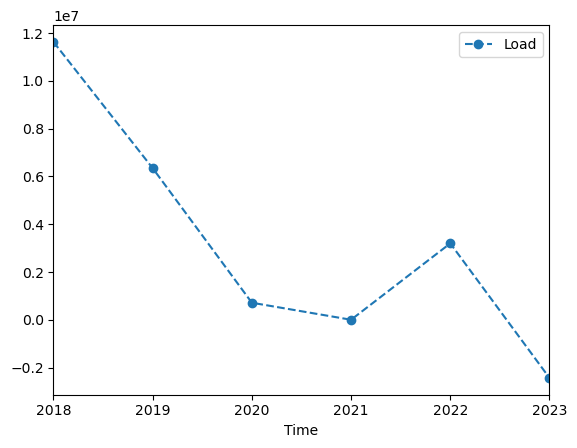

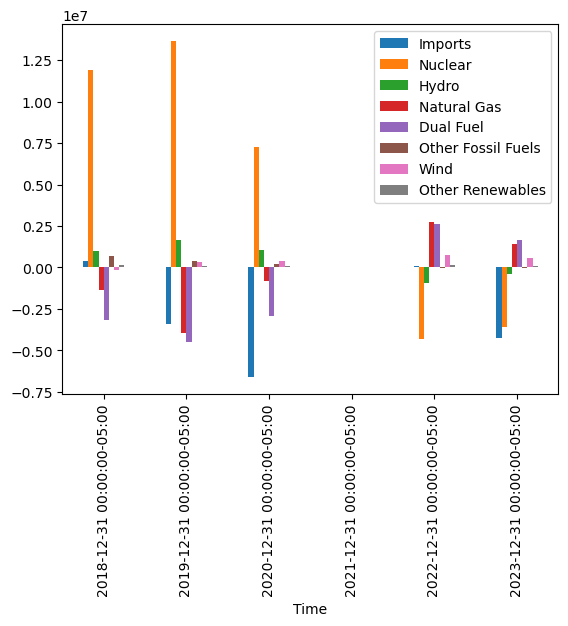

In [126]:
# fig, ax = plt.subplots()
ax =(demand.to_frame().resample('Y').sum().loc[:"2023"] - demand.to_frame().resample("Y").sum().loc['2021'].values).plot(linestyle='--', marker='o')
(nyiso_combined.resample('Y').sum().loc[:"2023"] - nyiso_combined.resample('Y').sum().loc["2021"].values).plot(ax=ax, kind='bar')


# Get interchange amount

In [29]:
eia = EIA(eia_api_key)

In [67]:
nyis_eia = eia.get_dataset(dataset="electricity/rto/region-data",
                start="2019-01-01",
                end="2019-01-02",
                facets={'respondent':['NYIS']},
                frequency='hourly',
                n_workers=4,
                verbose=True)

Fetching data from https://api.eia.gov/v2/electricity/rto/region-data/data/
Params: {'start': '2019-01-01T00', 'end': '2019-01-02T00', 'frequency': 'hourly', 'data': ['value'], 'facets': {'respondent': ['NYIS']}, 'offset': 0, 'length': 5000, 'sort': [{'column': 'period', 'direction': 'asc'}, {'column': 'respondent', 'direction': 'asc'}, {'column': 'type', 'direction': 'asc'}]}
Concurrent workers: 4
Total records: 100
Total pages: 1
Fetching data:


In [68]:
nyis_eia = nyis_eia.set_index('Interval Start').drop(columns=['Interval End','Respondent','Respondent Name'])

In [69]:
nyis_eia

,Load,Load Forecast,Net Generation,Total Interchange
Interval Start,,,,
2018-12-31 23:00:00+00:00,19586.0,19468.0,16454.0,-3132.0
2019-01-01 00:00:00+00:00,18891.0,18752.0,15841.0,-3050.0
2019-01-01 01:00:00+00:00,18198.0,17925.0,15150.0,-3048.0
2019-01-01 02:00:00+00:00,17423.0,17091.0,14718.0,-2705.0
2019-01-01 03:00:00+00:00,16613.0,16306.0,14103.0,-2510.0
2019-01-01 04:00:00+00:00,15774.0,15617.0,13191.0,-2583.0
2019-01-01 05:00:00+00:00,15053.0,14858.0,12725.0,-2328.0
2019-01-01 06:00:00+00:00,14481.0,14216.0,12473.0,-2008.0
2019-01-01 07:00:00+00:00,13927.0,13691.0,12262.0,-1665.0


In [70]:
nyis_eia.tz_convert('US/Eastern').loc['2019']

,Load,Load Forecast,Net Generation,Total Interchange
Interval Start,,,,
2019-01-01 00:00:00-05:00,15053.0,14858.0,12725.0,-2328.0
2019-01-01 01:00:00-05:00,14481.0,14216.0,12473.0,-2008.0
2019-01-01 02:00:00-05:00,13927.0,13691.0,12262.0,-1665.0
2019-01-01 03:00:00-05:00,13566.0,13356.0,12054.0,-1512.0
2019-01-01 04:00:00-05:00,13353.0,13230.0,11927.0,-1426.0
2019-01-01 05:00:00-05:00,13475.0,13345.0,12173.0,-1302.0
2019-01-01 06:00:00-05:00,13846.0,13690.0,12430.0,-1416.0
2019-01-01 07:00:00-05:00,14199.0,13973.0,12548.0,-1651.0
2019-01-01 08:00:00-05:00,14570.0,14346.0,12784.0,-1786.0


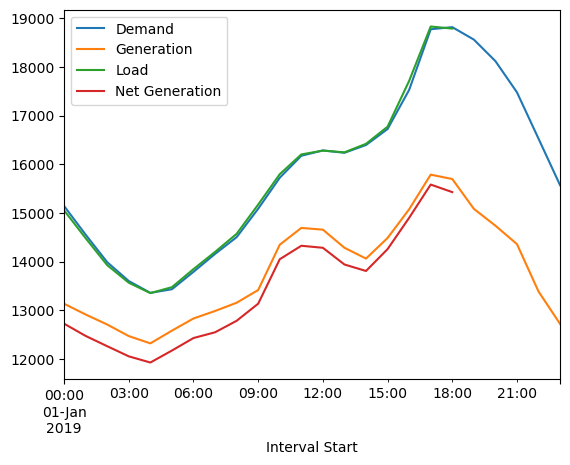

In [71]:
fig, ax = plt.subplots()
demand.plot(ax=ax, label='Demand')
fuel_mix.sum(axis=1).plot(ax=ax, label='Generation')
nyis_eia.tz_convert('US/Eastern').loc['2019', ['Load','Net Generation']].plot(ax=ax)
ax.legend()

# OLD ANALYSIS FROM 2023

In [2]:
months = list(calendar.month_name)[1:]

In [3]:
path = '../../data_misc/eia_form923/**/EIA923_Schedules_2_3_4_5_M_12_*_Final_Revision.xlsx'
files = glob.glob(path)
files.append('../../data_misc/eia_form923/f923_2013/EIA923_Schedules_2_3_4_5_2013_Final_Revision.xlsx')
files.append('../../data_misc/eia_form923/f923_2021/EIA923_Schedules_2_3_4_5_M_12_2021_Final.xlsx')

years = np.arange(2018,2022,1).astype('int')
files.sort()
for x, y in zip(years, files):
    print(x,y)

2018 ../../data_misc/eia_form923/f923_2012/EIA923_Schedules_2_3_4_5_M_12_2012_Final_Revision.xlsx
2019 ../../data_misc/eia_form923/f923_2013/EIA923_Schedules_2_3_4_5_2013_Final_Revision.xlsx
2020 ../../data_misc/eia_form923/f923_2014/EIA923_Schedules_2_3_4_5_M_12_2014_Final_Revision.xlsx
2021 ../../data_misc/eia_form923/f923_2015/EIA923_Schedules_2_3_4_5_M_12_2015_Final_Revision.xlsx


In [4]:
files[-4:]

['../../data_misc/eia_form923/f923_2018/EIA923_Schedules_2_3_4_5_M_12_2018_Final_Revision.xlsx',
 '../../data_misc/eia_form923/f923_2019/EIA923_Schedules_2_3_4_5_M_12_2019_Final_Revision.xlsx',
 '../../data_misc/eia_form923/f923_2020/EIA923_Schedules_2_3_4_5_M_12_2020_Final_Revision.xlsx',
 '../../data_misc/eia_form923/f923_2021/EIA923_Schedules_2_3_4_5_M_12_2021_Final.xlsx']

In [5]:
path = '../../data_misc/eia_data/emissions20*.xlsx'
efiles = glob.glob(path)

efiles.sort()
for x, y in zip(years, efiles):
    print(x,y)

2018 ../../data_misc/eia_data/emissions2018.xlsx
2019 ../../data_misc/eia_data/emissions2019.xlsx
2020 ../../data_misc/eia_data/emissions2020.xlsx
2021 ../../data_misc/eia_data/emissions2021.xlsx


# Get the generation data from EIA Form 923 for each emitting plant in NY

In [6]:
zero_emission_codes = ["SUN","GEO","OTH","HPS","HYC","NUC","ORW","WND"]

In [7]:
f = files[-1]
df = pd.read_excel(f,skiprows=5, na_values='.',
                   usecols=[0,3,6,14,15]+list(np.arange(79,91,1).astype('int')))

In [43]:
final_df = pd.DataFrame({'Month':months})
co2_rate = {}

In [47]:
for k,(i, j) in enumerate(zip(files[-4:], efiles)):
    print(k, i, j)
    f = files[-1]
    df = pd.read_excel(i,skiprows=5, na_values='.',
                       usecols=[0,3,6,14,15]+list(np.arange(79,91,1).astype('int')))
    df_ny = df[(df['Plant State']=='NY')&(df['Plant Id'] < 99999)&(~df['AER\nFuel Type Code'].isin(zero_emission_codes))]
    df_ny.groupby('Plant Name').sum().iloc[:,1:15].sum(axis=1)*1000

    # READ emissions data
    edf = pd.read_excel(j, skiprows=1)
    edf = edf[edf['Plant Code'].isin(df_ny['Plant Id'].values)].groupby('Plant Name').sum()[['Generation (kWh)',
                                                                                             'Metric Tonnes of CO2 Emissions']]
    edf['CO2 Rate (Tonne/kWh)'] = edf.iloc[:,1]/edf.iloc[:,0]

    df_ny_gen = df_ny[df_ny['Plant Name'].isin(edf.index.values)].groupby('Plant Name').sum().iloc[:,1:]
    edf_match = edf[(edf.index.isin(df_ny_gen.index.values))&(edf['Generation (kWh)']>0)]
    edf_match['CO2 Rate (Tonne/MWh)'] = edf_match['CO2 Rate (Tonne/kWh)']*1e3

    co2 = df_ny_gen.multiply(edf_match['CO2 Rate (Tonne/MWh)'],axis=0).sum(axis=0).values
    y = 2018+k
    final_df[f'{y}'] = co2
    co2_rate[f'{y}'] = edf_match['CO2 Rate (Tonne/MWh)'].sum()

0 ../../data_misc/eia_form923/f923_2018/EIA923_Schedules_2_3_4_5_M_12_2018_Final_Revision.xlsx ../../data_misc/eia_data/emissions2018.xlsx
1 ../../data_misc/eia_form923/f923_2019/EIA923_Schedules_2_3_4_5_M_12_2019_Final_Revision.xlsx ../../data_misc/eia_data/emissions2019.xlsx
2 ../../data_misc/eia_form923/f923_2020/EIA923_Schedules_2_3_4_5_M_12_2020_Final_Revision.xlsx ../../data_misc/eia_data/emissions2020.xlsx
3 ../../data_misc/eia_form923/f923_2021/EIA923_Schedules_2_3_4_5_M_12_2021_Final.xlsx ../../data_misc/eia_data/emissions2021.xlsx


In [48]:
final_df.set_index('Month',inplace=True)

In [49]:
final_df

,2021,2018,2019,2020
Month,,,,
January,2.209024e+06,2.826108e+06,2.322773e+06,1.996027e+06
February,1.885290e+06,1.556969e+06,1.862208e+06,1.874304e+06
March,1.708783e+06,1.814657e+06,1.802658e+06,1.920999e+06
April,1.385598e+06,1.710736e+06,1.476082e+06,1.369798e+06
May,1.831803e+06,1.947297e+06,1.453577e+06,1.505068e+06
June,2.691186e+06,2.284630e+06,1.954267e+06,2.419796e+06
July,2.975032e+06,3.390081e+06,3.405657e+06,3.686715e+06
August,3.302219e+06,3.528874e+06,2.884714e+06,3.241764e+06
September,2.175396e+06,2.634774e+06,1.996884e+06,2.414002e+06


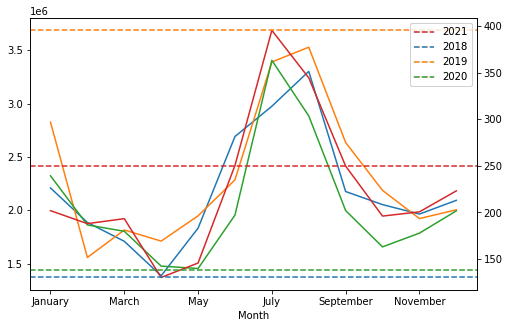

In [51]:
fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx()
final_df.plot(ax=ax)
colors={2018:'tab:blue',2019:'tab:orange',2020:'tab:green',2021:'tab:red',}
# for y,v in final_df.mean(axis=0).items():
for y,v in co2_rate.items():
    ax2.axhline(y=v, label=f'{y}', linestyle='--', color=colors[int(y)])
ax.legend()
ax2.legend()